In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.chdir('/home/hrai/codes/hpe_library')
from hpe_library.lib_import import *
from hpe_library. my_utils import *
# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result_5actions"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
#assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
#assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

os.chdir(motionbert_root)
from lib.utils.tools import *
from lib.utils.learning import *
from lib.model.loss import *
from lib.data.dataset_action import Fit3DAction
from lib.model.model_action import ActionNet

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

def parse_args(input_args=[]):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pretrain.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-freq', '--print_freq', default=100)
    parser.add_argument('-ms', '--selection', default='latest_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    opts = parser.parse_args(input_args)
    return opts

def validate(test_loader, model, criterion):
    model.eval()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    with torch.no_grad():
        end = time.time()
        for idx, (batch_input, batch_gt) in tqdm(enumerate(test_loader)):
            batch_size = len(batch_input)    
            if torch.cuda.is_available():
                batch_gt = batch_gt.cuda()
                batch_input = batch_input.cuda()
            output = model(batch_input)    # (N, num_classes)
            loss = criterion(output, batch_gt)

            # update metric
            losses.update(loss.item(), batch_size)
            acc1, acc5 = accuracy(output, batch_gt, topk=(1, 5))
            top1.update(acc1[0], batch_size)
            top5.update(acc5[0], batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if (idx+1) % opts.print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Acc@5 {top5.val:.3f} ({top5.avg:.3f})\t'.format(
                       idx, len(test_loader), batch_time=batch_time,
                       loss=losses, top1=top1, top5=top5))
    return losses.avg, top1.avg, top5.avg

opts = parse_args(['--config', 'configs/action/MB_ft_Kookmin2_train_s11-12_augment_243_50_test_augment_243_50.yaml',
                   '--evaluate', 'checkpoint/action/FT_MB_release_MB_Kookmin2_Action_Train_S11-12_Augment_243_50_Test_Augment_243_50/best_epoch.bin'])
args = get_config(opts.config)

In [4]:
args.batch_size = 1

In [5]:
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 8,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
data_path = 'data/action/%s.pkl' % args.dataset
kookmin_val = Fit3DAction(data_path=data_path, data_split='test', n_frames=args.clip_len, random_move=False, scale_range=args.scale_range_test)
test_loader = DataLoader(kookmin_val, **testloader_params)

In [6]:
model_backbone = load_backbone(args)
model = ActionNet(backbone=model_backbone, dim_rep=args.dim_rep, num_classes=args.action_classes, dropout_ratio=args.dropout_ratio, version=args.model_version, hidden_dim=args.hidden_dim, num_joints=args.num_joints)
criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model = model.cuda()
    
if opts.resume or opts.evaluate:
    chk_filename = opts.evaluate if opts.evaluate else opts.resume
    print('Loading checkpoint', chk_filename)
    checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'], strict=True)
    
model = model.eval()

Loading checkpoint checkpoint/action/FT_MB_release_MB_Kookmin2_Action_Train_S11-12_Augment_243_50_Test_Augment_243_50/best_epoch.bin


In [7]:
if opts.evaluate:
    test_loss, test_top1, test_top5 = validate(test_loader, model, criterion)
    print('Loss {loss:.4f} \t'
            'Acc@1 {top1:.3f} \t'
            'Acc@5 {top5:.3f} \t'.format(loss=test_loss, top1=test_top1, top5=test_top5))

0it [00:00, ?it/s]

101it [00:19,  4.97it/s]

Test: [99/898]	Time 0.195 (0.197)	Loss 0.0001 (0.0319)	Acc@1 100.000 (98.750)	Acc@5 100.000 (100.000)	


201it [00:39,  5.15it/s]

Test: [199/898]	Time 0.195 (0.196)	Loss 0.3030 (0.0776)	Acc@1 87.500 (98.250)	Acc@5 100.000 (100.000)	


301it [00:59,  5.13it/s]

Test: [299/898]	Time 0.194 (0.197)	Loss 0.0000 (0.1505)	Acc@1 100.000 (95.917)	Acc@5 100.000 (100.000)	


401it [01:19,  5.04it/s]

Test: [399/898]	Time 0.193 (0.197)	Loss 0.0000 (0.1540)	Acc@1 100.000 (95.719)	Acc@5 100.000 (99.969)	


501it [01:38,  5.16it/s]

Test: [499/898]	Time 0.193 (0.196)	Loss 0.0000 (0.1579)	Acc@1 100.000 (95.700)	Acc@5 100.000 (99.975)	


601it [01:57,  5.22it/s]

Test: [599/898]	Time 0.191 (0.196)	Loss 0.0000 (0.1616)	Acc@1 100.000 (95.667)	Acc@5 100.000 (99.958)	


701it [02:17,  5.10it/s]

Test: [699/898]	Time 0.194 (0.196)	Loss 0.0001 (0.1488)	Acc@1 100.000 (95.821)	Acc@5 100.000 (99.964)	


801it [02:37,  5.14it/s]

Test: [799/898]	Time 0.195 (0.196)	Loss 0.0005 (0.1401)	Acc@1 100.000 (95.938)	Acc@5 100.000 (99.969)	


898it [02:56,  5.10it/s]

Loss 0.1386 	Acc@1 95.961 	Acc@5 99.972 	


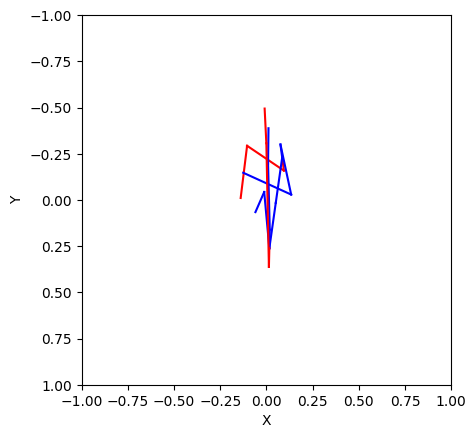

In [39]:
pose_2d_list = batch_input[0][0].detach().cpu().numpy()
fig = plt.figure(3)
fig.clear()
ax = axes_2d(fig, normalize=True)
draw_2d_pose(ax, pose_2d_list[100], normalize=True)

### Load mmpose 2D pose

In [8]:
import torch
import numpy as np
import os
import random
import copy
from torch.utils.data import Dataset, DataLoader
from lib.utils.utils_data import crop_scale, resample
from lib.utils.tools import read_pkl

def make_cam(x, img_shape):
    '''
        Input: x (M x T x V x C)
               img_shape (height, width)
    '''
    h, w = img_shape
    if w >= h:
        x_cam = x / w * 2 - 1
    else:
        x_cam = x / h * 2 - 1
    return x_cam

def human_tracking(x):
    M, T = x.shape[:2]
    if M==1:
        return x
    else:
        diff0 = np.sum(np.linalg.norm(x[0,1:] - x[0,:-1], axis=-1), axis=-1)        # (T-1, V, C) -> (T-1)
        diff1 = np.sum(np.linalg.norm(x[0,1:] - x[1,:-1], axis=-1), axis=-1)
        x_new = np.zeros(x.shape)
        sel = np.cumsum(diff0 > diff1) % 2
        sel = sel[:,None,None]
        x_new[0][0] = x[0][0]
        x_new[1][0] = x[1][0]
        x_new[0,1:] = x[1,1:] * sel + x[0,1:] * (1-sel)
        x_new[1,1:] = x[0,1:] * sel + x[1,1:] * (1-sel)
        return x_new
    
def coco2h36m(x):
    '''
        Input: x (M x T x V x C)
        
        COCO: {0-nose 1-Leye 2-Reye 3-Lear 4Rear 5-Lsho 6-Rsho 7-Lelb 8-Relb 9-Lwri 10-Rwri 11-Lhip 12-Rhip 13-Lkne 14-Rkne 15-Lank 16-Rank}
        
        H36M:
        0: 'root',
        1: 'rhip',
        2: 'rkne',
        3: 'rank',
        4: 'lhip',
        5: 'lkne',
        6: 'lank',
        7: 'belly',
        8: 'neck',
        9: 'nose',
        10: 'head',
        11: 'lsho',
        12: 'lelb',
        13: 'lwri',
        14: 'rsho',
        15: 'relb',
        16: 'rwri'
    '''
    y = np.zeros(x.shape)
    y[:,:,0,:] = (x[:,:,11,:] + x[:,:,12,:]) * 0.5
    y[:,:,1,:] = x[:,:,12,:]
    y[:,:,2,:] = x[:,:,14,:]
    y[:,:,3,:] = x[:,:,16,:]
    y[:,:,4,:] = x[:,:,11,:]
    y[:,:,5,:] = x[:,:,13,:]
    y[:,:,6,:] = x[:,:,15,:]
    y[:,:,8,:] = (x[:,:,5,:] + x[:,:,6,:]) * 0.5
    y[:,:,7,:] = (y[:,:,0,:] + y[:,:,8,:]) * 0.5
    y[:,:,9,:] = x[:,:,0,:]
    y[:,:,10,:] = (x[:,:,1,:] + x[:,:,2,:]) * 0.5
    y[:,:,11,:] = x[:,:,5,:]
    y[:,:,12,:] = x[:,:,7,:]
    y[:,:,13,:] = x[:,:,9,:]
    y[:,:,14,:] = x[:,:,6,:]
    y[:,:,15,:] = x[:,:,8,:]
    y[:,:,16,:] = x[:,:,10,:]
    return y

m = nn.Softmax(dim=1)

In [9]:
data = readpkl('data/action/kookmin2_mmpose_train_s11-12.pkl')
data.keys(), len(data['split']['test']), len(data['annotations']), data['annotations'][0].keys()

(dict_keys(['split', 'annotations']),
 280,
 350,
 dict_keys(['frame_dir', 'img_shape', 'num_person_raw', 'keypoint', 'keypoint_score', 'total_frames', 'label']))

In [34]:
subject_list = ['S15']
action_list = ['kneeup']#, 'benchpress', 'cat', 'yoga', 'burpee' , 'pushup', 'squat'] # ['squat', 'burpee' , 'pushup', 'kneeup', 'yoga', 'benchpress', 'cat']
cam_list = ['2']

from itertools import product
items = [subject_list, action_list, cam_list]
target_list = list(product(*items))
target_list

[('S15', 'kneeup', '2')]

In [35]:
video_list = np.array([data['annotations'][i]['frame_dir'] for i in range(len(data['annotations']))])
video_list

array(['S11_benchpress_1', 'S12_pushup_1', 'S11_kneeup_4', 'S20_burpee_4',
       'S11_benchpress_2', 'S20_benchpress_1', 'S11_kneeup_3',
       'S11_cat_2', 'S20_squat_5', 'S12_kneeup_2', 'S11_benchpress_5',
       'S11_burpee_2', 'S11_burpee_1', 'S20_cat_2', 'S12_yoga_3',
       'S20_squat_2', 'S11_squat_4', 'S11_squat_2', 'S20_cat_5',
       'S11_cat_1', 'S20_pushup_5', 'S20_pushup_3', 'S11_burpee_3',
       'S20_benchpress_4', 'S20_pushup_4', 'S11_yoga_4', 'S12_kneeup_1',
       'S11_cat_5', 'S11_squat_3', 'S20_benchpress_3', 'S11_pushup_4',
       'S20_burpee_2', 'S20_yoga_3', 'S20_yoga_2', 'S11_squat_1',
       'S11_pushup_5', 'S11_burpee_4', 'S20_kneeup_3', 'S12_kneeup_3',
       'S20_burpee_5', 'S12_burpee_4', 'S12_squat_5', 'S11_benchpress_3',
       'S12_burpee_2', 'S11_yoga_3', 'S12_cat_2', 'S12_cat_3',
       'S20_burpee_1', 'S12_kneeup_4', 'S12_benchpress_3', 'S12_pushup_4',
       'S20_cat_4', 'S20_kneeup_5', 'S12_pushup_2', 'S11_benchpress_4',
       'S11_yoga_5', 'S20_c

In [36]:
len_per_video = 300
batch_input = None
batch_input_h36m = None
keypoint_for_vis = []
total_frames = []
for target in target_list:
    subject, action, cam_id = target
    video_name = f'{subject}_{action}_{cam_id}'
    video_idx = np.where(video_list == video_name)[0][0]
    print(video_name, video_idx)
    frames = np.array(get_video_frame_kookmin(subject, action, cam_id))

    # get 2d input
    sample = data['annotations'][video_idx]
    resample_id = resample(ori_len=sample['total_frames'], target_len=len_per_video, randomness=False) # 전체 비디오 프레임 수를 target_len 개수로 줄임
    total_frames.append(frames[resample_id])
    keypoint_for_vis.append(data['annotations'][video_idx]['keypoint'][0][resample_id])
    motion_cam = make_cam(x=sample['keypoint'], img_shape=sample['img_shape'])
    motion_cam = human_tracking(motion_cam)
    motion_cam_h36m = motion_cam.copy()
    #motion_cam = coco2h36m(motion_cam)
    motion_conf = sample['keypoint_score'][..., None]
    motion = np.concatenate((motion_cam[:,resample_id], motion_conf[:,resample_id]), axis=-1)
    motion_h36m = np.concatenate((motion_cam_h36m[:,resample_id], motion_conf[:,resample_id]), axis=-1)
    if motion.shape[0]==1:                                  # Single person, make a fake zero person
        fake = np.zeros(motion.shape)
        motion = np.concatenate((motion, fake), axis=0)
        motion_h36m = np.concatenate((motion_h36m, fake), axis=0)
    print(motion.shape)
    if batch_input is None:
        batch_input = torch.from_numpy(np.array(motion)).float().cuda()
    else:
        batch_input = torch.cat((batch_input, torch.from_numpy(np.array(motion)).float().cuda()), dim=1)
    if batch_input_h36m is None:
        batch_input_h36m = torch.from_numpy(np.array(motion_h36m)).float().cuda()
    else:
        batch_input_h36m = torch.cat((batch_input_h36m, torch.from_numpy(np.array(motion_h36m)).float().cuda()), dim=1)
    
batch_input = batch_input.reshape(1, 2, -1, 17, 3)
batch_input_h36m = batch_input_h36m.reshape(1, 2, -1, 17, 3)
print(batch_input.shape, batch_input_h36m.shape)

# concat zero 243 frames at the beginning
batch_input = torch.cat([torch.zeros([1, 2, 243, 17, 3]).float().cuda(), batch_input], dim=2)

S15_kneeup_2 240
(2, 300, 17, 3)
torch.Size([1, 2, 300, 17, 3]) torch.Size([1, 2, 300, 17, 3])


In [37]:
keypoint_for_vis = np.array(keypoint_for_vis).reshape(-1, 17, 2)

In [38]:
total_frames = np.array(total_frames).reshape(-1, 1920, 1080, 3)

print(total_frames.shape, keypoint_for_vis.shape)

(300, 1920, 1080, 3) (300, 17, 2)


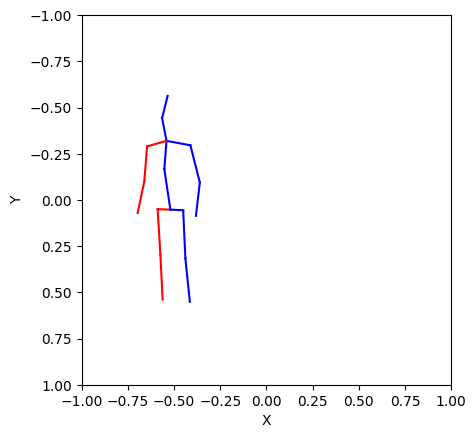

In [47]:
fig = plt.figure(1)
fig.clear()
ax = axes_2d(fig, normalize=True)
draw_2d_pose(ax, batch_input[0, 0, 243])


In [32]:
ref_input_data = torch.zeros([1, 2, 243, 17, 3])
pred_frame = []
output_frame = []
for frame_num in tqdm(range(len(batch_input[0,0])-243)):
    # if frame_num < 243:
    #     input_data = ref_input_data.clone().detach()
    #     input_data[:, :, :frame_num] = batch_input[0, :, :frame_num]
    # else:
    input_data = ref_input_data.clone().detach()
    input_data = batch_input[:, :, frame_num:frame_num+243]
    #print(input_data.shape)
    output = model(input_data)
    
    maxk = max((1,))
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    pred_frame.append(pred.item())
    output_frame.append(m(output).cpu().detach().numpy())

  0%|          | 0/2100 [00:00<?, ?it/s]

100%|██████████| 2100/2100 [01:23<00:00, 25.26it/s]


  0%|          | 0/2100 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1300, 500) to (1312, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
100%|██████████| 2100/2100 [03:21<00:00, 10.42it/s]


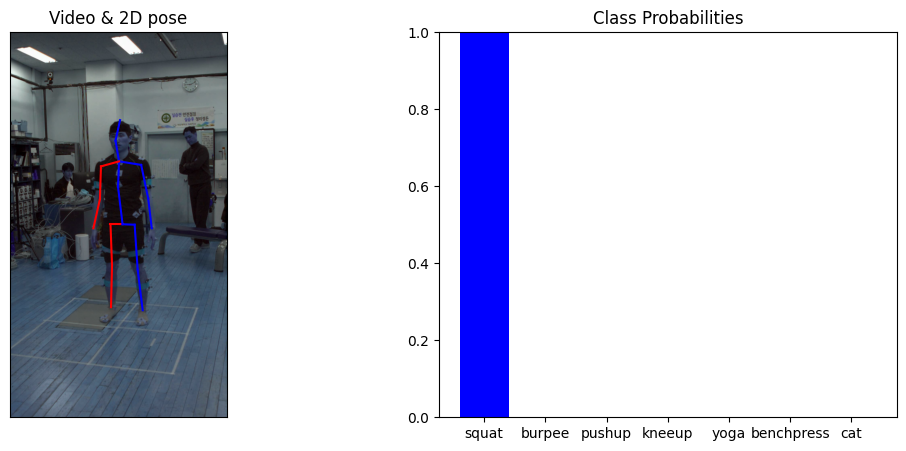

In [33]:
class_names = ['squat', 'burpee', 'pushup', 'kneeup', 'yoga', 'benchpress', 'cat']
fig = plt.figure(4, figsize=(13, 5))
fig.clear()
ax = axes_2d(fig, loc=121, W=1080, H=1920, show_axis=False)
ax.grid('off')
ax.set_title('Video & 2D pose')
#ax = axes_2d(fig, loc=121, normalize=True)
ax2 = fig.add_subplot(122)
ax2.set_ylim(0, 1)
ax2.set_title('Class Probabilities')
videowriter = imageio.get_writer(f'class_probability_example.mp4', fps=60)
for frame_num in tqdm(range(len(output_frame))):
    clear_axes([ax, ax2])
    # ax
    ax.imshow(total_frames[frame_num])
    draw_2d_pose(ax, keypoint_for_vis[frame_num], W=1080, H=1920)
    # ax2
    ax2.bar(class_names, output_frame[frame_num][0], color='blue')
    
    # save image
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
    videowriter.append_data(image_from_plot)
videowriter.close()